# LOADING THE LIBRARIES

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14,8]
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier as clf
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from joblib import load, dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import metrics as mt
from tensorflow.keras import losses, activations, optimizers
from hyperopt import tpe, hp, fmin, space_eval, Trials
from hyperopt.pyll import scope as hpScope
from hyperopt.pyll.stochastic import sample as hpSample

## **1 IMPORTING THE DATASETS**

In [82]:
train = pd.read_csv('train.csv')
nTrain = train.copy()
test = pd.read_csv('test.csv')
nTest = test.copy()

## **2 EXPLORING THE DATASETS**

In [83]:
train.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35.0,5.0,8.0,1.0,0.0,49.0,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1.0,30.0,5.0,4.0,0.0,0.0,60.0,0.0


In [84]:
test.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45869 entries, 0 to 45868
Data columns (total 14 columns):
employee_id             45869 non-null int64
department              45869 non-null object
region                  45868 non-null object
education               43839 non-null object
gender                  45868 non-null object
recruitment_channel     45868 non-null object
no_of_trainings         45868 non-null float64
age                     45868 non-null float64
previous_year_rating    42390 non-null float64
length_of_service       45868 non-null float64
KPIs_met >80%           45868 non-null float64
awards_won?             45868 non-null float64
avg_training_score      45868 non-null float64
is_promoted             45868 non-null float64
dtypes: float64(8), int64(1), object(5)
memory usage: 4.9+ MB


In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non-null int64
department              23490 non-null object
region                  23490 non-null object
education               22456 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    21678 non-null float64
length_of_service       23490 non-null int64
KPIs_met >80%           23490 non-null int64
awards_won?             23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [87]:
nTrain.describe(exclude='number')

,department,region,education,gender,recruitment_channel
count,45869,45868,43839,45868,45868
unique,10,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,14063,10290,30687,32212,25485


In [88]:
nTest.describe(exclude='number')

,department,region,education,gender,recruitment_channel
count,23490,23490,22456,23490,23490
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,7315,5299,15578,16596,13078


In [89]:
nTrain.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,45869.000000,45868.000000,45868.000000,42390.000000,45868.000000,45868.000000,45868.000000,45868.000000,45868.000000
mean,39172.131265,1.251897,34.800580,3.330880,5.861516,0.352686,0.023066,63.412706,0.085092
std,22579.916045,0.607466,7.648853,1.262715,4.277540,0.477811,0.150115,13.371145,0.279022
min,2.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19659.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39175.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58715.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78297.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [90]:
nTest.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.358834,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.479668,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000


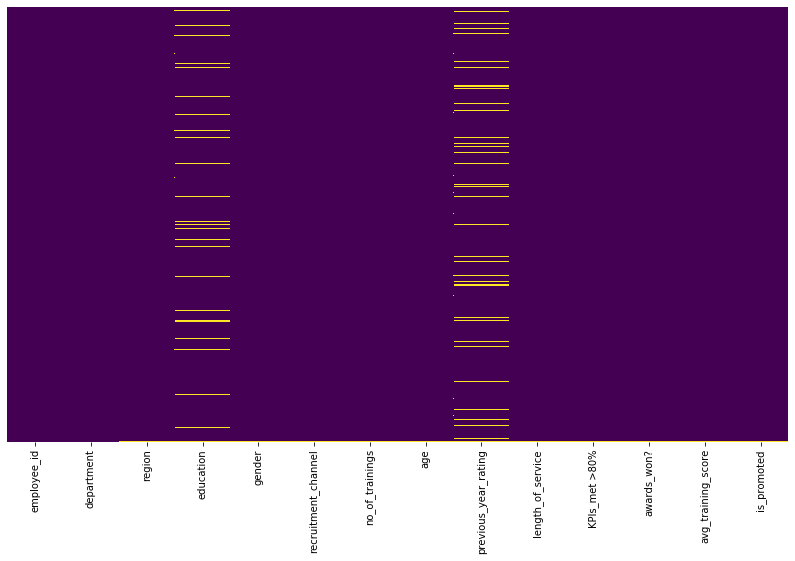

In [91]:
sns.heatmap(nTrain.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

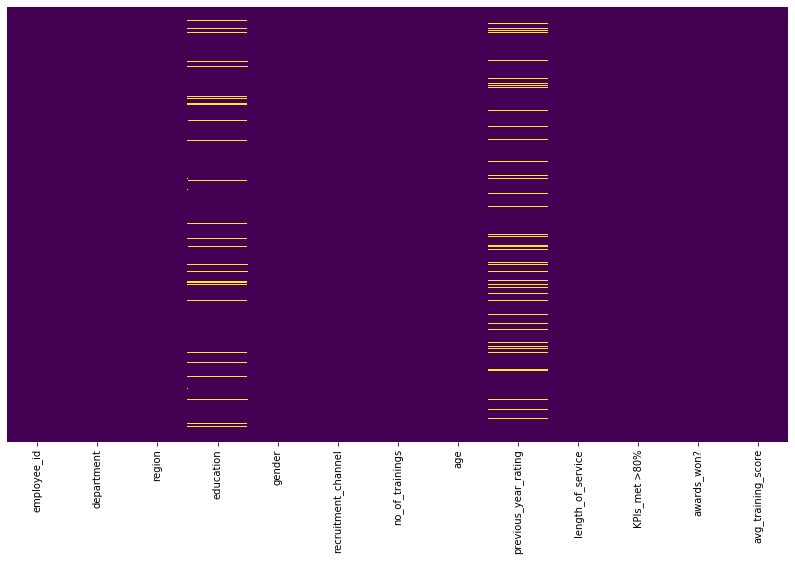

In [92]:
sns.heatmap(nTest.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

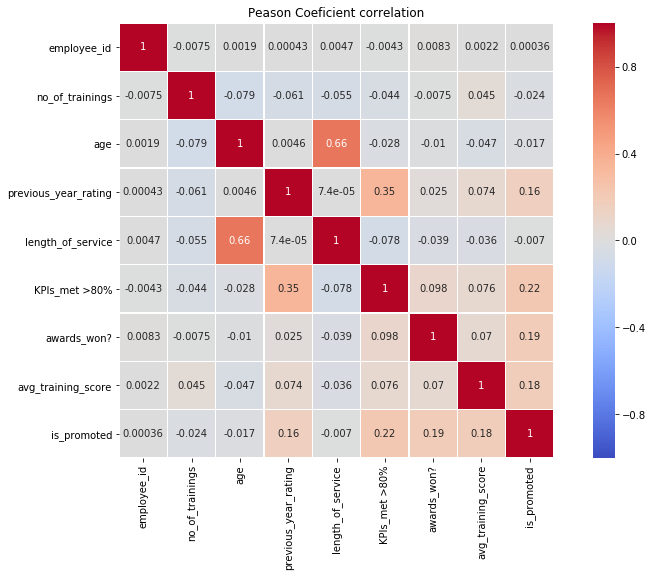

In [93]:
plt.title('Peason Coeficient correlation')
sns.heatmap(train.corr(),vmax=1,vmin=-1,linewidths=0.1,annot=True,
           linecolor='white',cmap='coolwarm',square=True)

In [94]:
# sns.barplot()

## **3 FEATURE ENGINEERING**

### 3.1 RENAMING SOME VARIABLES

In [95]:
print(nTrain.columns)
print(nTest.columns)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')
Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score'],
      dtype='object')


In [96]:
nTrain.rename(columns={'employee_id':'id','KPIs_met >80%':'kpi',
                       'awards_won?':'awards'},inplace=True)
print(nTrain.columns)
nTest.rename(columns={'employee_id':'id','KPIs_met >80%':'kpi',
                       'awards_won?':'awards'},inplace=True)
print(nTest.columns)

Index(['id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpi', 'awards', 'avg_training_score',
       'is_promoted'],
      dtype='object')
Index(['id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpi', 'awards', 'avg_training_score'],
      dtype='object')


### 3.2 WORKING WITH VARIABLES

In [97]:
print(nTrain.nunique())
print()
print(nTest.nunique())

id                      45869
department                 10
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
kpi                         2
awards                      2
avg_training_score         61
is_promoted                 2
dtype: int64

id                      23490
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings             9
age                        41
previous_year_rating        5
length_of_service          34
kpi                         2
awards                      2
avg_training_score         61
dtype: int64


In [98]:
nTrain.drop(labels='id',axis=1,inplace=True)
nTest.drop('id',1,inplace=True)

### 3.3 DEALING WITH MISSING VALUES

- **DROPPING NA ROWS**

In [99]:
nTrain.dropna(subset=nTrain.iloc[:,[1,3,4,5,6,8,9,10,11,12]].columns,inplace=True)

**Now, I am going  to make options for this  model.**
- **1 droping all rows, which contain NA values.**
- **2 The other option is by filling the missing values by attribute 'method' in fillna() function.**

- **FULL OUT**

In [100]:
# nTrain.dropna(inplace=True)

- **FILLING WITH A METHOD**

In [101]:
nTrain.previous_year_rating.value_counts()

3.0    15513
5.0     9889
4.0     8232
1.0     5228
2.0     3528
Name: previous_year_rating, dtype: int64

In [102]:
nTrain.education.value_counts()

Bachelor's          30687
Master's & above    12495
Below Secondary       657
Name: education, dtype: int64

In [103]:
# nTrain.ffill().isna().any()

In [104]:
# nTrain.ffill(inplace=True)
# nTest.bfill(inplace=True)
nTrain.fillna(method='bfill',inplace=True)
nTrain.fillna(method='ffill',inplace=True)
nTest.fillna(method='bfill',inplace=True)

In [105]:
nTrain.previous_year_rating.value_counts()

3.0    16797
5.0    10702
4.0     8888
1.0     5655
2.0     3826
Name: previous_year_rating, dtype: int64

In [106]:
nTrain.education.value_counts()

Bachelor's          32075
Master's & above    13113
Below Secondary       680
Name: education, dtype: int64

- **CONVERTING ALL FLOATS TO INTEGERS**

In [107]:
def conversion(data):
    for i in data.columns:
        if np.issubdtype(data[i].dtype, np.number) == True:
            data[i] = data[i].astype(np.int64)
    return data

In [108]:
nTrain = conversion(nTrain)
nTest = conversion(nTest)

- **CONVERTING EACH NUMERICCATEGORICAL VARIABLE TO CATEGORICAL**

In [109]:
nTrain.dtypes

department              object
region                  object
education               object
gender                  object
recruitment_channel     object
no_of_trainings          int64
age                      int64
previous_year_rating     int64
length_of_service        int64
kpi                      int64
awards                   int64
avg_training_score       int64
is_promoted              int64
dtype: object

In [110]:
X = nTrain['no_of_trainings,previous_year_rating,kpi,awards'.split(',')].astype(np.object_)
Y = nTest['no_of_trainings,previous_year_rating,kpi,awards'.split(',')].astype(np.object_)

In [111]:
nTrain['no_of_trainings,previous_year_rating,kpi,awards'.split(',')] = X
nTest['no_of_trainings,previous_year_rating,kpi,awards'.split(',')] = Y

- **LET'S TAKE A LOOD AT EACH CATEGORICAL VARIABLE**

In [112]:
nTrain['department'].value_counts()

Sales & Marketing    14063
Operations            9458
Technology            6008
Procurement           5977
Analytics             4468
Finance               2115
HR                    2023
Legal                  899
R&D                    857
Name: department, dtype: int64

In [113]:
nTrain.loc[nTrain.department == 'Analyti','department'] = 'Analytics'

In [114]:
# droping a row that columns contains with one missing value
# as shown by the heatmap

In [115]:
def deep(data):
    for i in data.columns:
        if np.issubdtype(data[i].dtype, np.object_) == True:
            print(data[i].unique())

In [116]:
print(deep(nTrain))
print(deep(nTest))

['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
["Master's & above" "Bachelor's" 'Below Secondary']
['f' 'm']
['sourcing' 'other' 'referred']
[1 2 3 4 7 5 6 8 10 9]
[5 3 1 4 2]
[1 0]
[0 1]
None
['Technology' 'HR' 'Sales & Marketing' 'Procurement' 'Finance' 'Analytics'
 'Operations' 'Legal' 'R&D']
['region_26' 'region_4' 'region_13' 'region_2' 'region_29' 'region_7'
 'region_22' 'region_16' 'region_17' 'region_24' 'region_11' 'region_27'
 'region_9' 'region_20' 'region_34' 'region_23' 'region_8' 'region_14'
 'region_31' 'region_19' '

In [117]:
nTrain.no_of_trainings.value_counts()

1     37158
2      6692
3      1464
4       389
5       106
6        37
7         9
10        5
8         5
9         3
Name: no_of_trainings, dtype: int64

In [118]:
nTrain.drop(nTrain[nTrain['no_of_trainings'] == 10].index,inplace=True)

- **3.4 MAPPING SOME FEATURES FOR PREVENTION**

In [119]:
data = {}
data['training'] = {1:'one',
                    2:'two',
                    3:'three',
                    4:'four',
                    5:'five',
                    6:'six',
                    7:'seven',
                    8:'eight',
                    9:'nine'}
data['rating'] = {1:'oneo',
                  2:'twot',
                  3:'threet',
                  4:'fourf',
                  5:'fivef'}
data['kpi'] = {0:'zero',1:'oneon'}
data['award'] = {0:'zeroz',1:'oneone'}

In [120]:
nTrain['no_of_trainings'] = nTrain['no_of_trainings'].map(data['training'])
nTest['no_of_trainings'] = nTest['no_of_trainings'].map(data['training'])
nTrain['previous_year_rating'] = nTrain['previous_year_rating'].map(data['rating'])
nTest['previous_year_rating'] = nTest['previous_year_rating'].map(data['rating'])
nTrain['kpi'] = nTrain['kpi'].map(data['kpi'])
nTest['kpi'] = nTest['kpi'].map(data['kpi'])
nTrain['awards'] = nTrain['awards'].map(data['award'])
nTest['awards'] = nTest['awards'].map(data['award'])

## **4 SPLITTING INDEPENDENT VARIABLES AND DEPENDENT VARIABLE**

In [121]:
X = nTrain.drop('is_promoted',axis=1)
Y = nTrain['is_promoted']

## **5 CREATING DUMMY VARIABLES**

In [122]:
def dummyVaraible(dataset):
    col = dataset
    for i in list(col.columns):
        if np.issubdtype(dataset[i].dtype, np.object_) == True:
            data = pd.get_dummies(dataset[i], drop_first= True)
            dataset = pd.concat([dataset,data], axis=1)
            dataset.drop(i,axis=1,inplace=True)
    return dataset

In [123]:
# dummyVaraible(X).shape
# dummyVaraible(X).columns
X = dummyVaraible(X)

In [124]:
# dummyVaraible(nTest).shape
# dummyVaraible(nTest).columns
nTest = dummyVaraible(nTest)
nTest.columns

Index(['age', 'length_of_service', 'avg_training_score', 'Finance', 'HR',
       'Legal', 'Operations', 'Procurement', 'R&D', 'Sales & Marketing',
       'Technology', 'region_10', 'region_11', 'region_12', 'region_13',
       'region_14', 'region_15', 'region_16', 'region_17', 'region_18',
       'region_19', 'region_2', 'region_20', 'region_21', 'region_22',
       'region_23', 'region_24', 'region_25', 'region_26', 'region_27',
       'region_28', 'region_29', 'region_3', 'region_30', 'region_31',
       'region_32', 'region_33', 'region_34', 'region_4', 'region_5',
       'region_6', 'region_7', 'region_8', 'region_9', 'Below Secondary',
       'Master's & above', 'm', 'referred', 'sourcing', 'five', 'four', 'nine',
       'one', 'seven', 'six', 'three', 'two', 'fourf', 'oneo', 'threet',
       'twot', 'zero', 'zeroz'],
      dtype='object')

In [125]:
print(X.shape)
print(nTest.shape)

(45863, 63)
(23490, 63)


## **6 FEATURE SCALING**

In [126]:
scale = StandardScaler()

In [127]:
def trainScale(train):
    data = train
    train = scale.fit_transform(train)
    train = pd.DataFrame(train, columns=data.columns)
    return train

def testScale(test):
    data = test
    test = scale.transform(test)
    test = pd.DataFrame(test, columns=data.columns)
    return test

In [128]:
X = trainScale(X)
nTest = testScale(nTest)

In [129]:
X.head()

,age,length_of_service,avg_training_score,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,...,seven,six,three,two,fourf,oneo,threet,twot,zero,zeroz
0,0.026210,0.500004,-1.077859,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,1.503823,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,-0.760049,-0.301687,-1.354649,0.153667
1,-0.627593,-0.435144,-0.255210,-0.219875,-0.214814,-0.141399,1.961918,-0.386958,-0.137992,-0.664972,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,-0.760049,-0.301687,0.738198,0.153667
2,-0.104550,0.266217,-1.003073,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,1.503823,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,1.315705,-0.301687,0.738198,0.153667
3,0.549253,0.967578,-1.003073,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,1.503823,...,-0.01401,-0.028415,-0.181587,2.419382,-0.490284,2.666759,-0.760049,-0.301687,0.738198,0.153667
4,1.333817,-0.902718,0.717010,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,-0.664972,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,1.315705,-0.301687,0.738198,0.153667


In [130]:
nTest.head()

,age,length_of_service,avg_training_score,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,...,seven,six,three,two,fourf,oneo,threet,twot,zero,zeroz
0,-1.412157,-1.136505,1.016155,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,-0.664972,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,1.315705,-0.301687,-1.354649,0.153667
1,-0.496832,-0.201357,-0.928287,-0.219875,4.655189,-0.141399,-0.509705,-0.386958,-0.137992,-0.664972,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,-0.374987,1.315705,-0.301687,0.738198,0.153667
2,-0.496832,-0.435144,-1.227431,-0.219875,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,1.503823,...,-0.01401,-0.028415,-0.181587,-0.413329,-0.490284,2.666759,-0.760049,-0.301687,0.738198,0.153667
3,-0.496832,0.733791,0.118721,-0.219875,-0.214814,-0.141399,-0.509705,2.584257,-0.137992,-0.664972,...,-0.01401,-0.028415,5.507012,-0.413329,-0.490284,-0.374987,-0.760049,3.314693,0.738198,0.153667
4,-0.627593,0.266217,-0.180424,4.548036,-0.214814,-0.141399,-0.509705,-0.386958,-0.137992,-0.664972,...,-0.01401,-0.028415,-0.181587,-0.413329,2.039633,-0.374987,-0.760049,-0.301687,0.738198,0.153667


## **7 SAMPLE MODEL**

In [76]:
classifier = clf(n_jobs=-1)

In [77]:
scores = cross_val_score(classifier,X,Y,cv=10)

In [80]:
print(scores)
print(scores.mean())

[0.93590582 0.93982995 0.93699586 0.93545573 0.93676406 0.93720017
 0.93916267 0.94025294 0.94112516 0.9385085 ]
0.9381200887127591


So without parameter  tuning our model did well, **by attaining 93% of accuracy.**

In [54]:
clf()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### 7.1 AUTOMATED HYPERPARAMETER WITH HYPEROPT

In [55]:
# hpSpace = {'booster':hp.choice('booster',['gbtree','dart']),
#            'colsample_bynode':hp.uniform('colsample_bynode',low=0.00,high=1),
#            'colsample_bylevel':hp.uniform('colsample_bylevel',low=0.00,high=1),
#            'colsample_bytree':hp.uniform('colsample_bytree',low=0.00,high=1),
#            'learning_rate':hp.uniform('learning_rate',low=0.00,high=10),
#            'max_depth':hpScope.int(hp.quniform('max_depht',low=1,high=15,q=1)),
#            'n_estimators':hpScope.int(hp.quniform('n_estimators',low=10000,high=50000,q=1)),
#            'subsample':hp.uniform('subsample',low=0.00,high=1)}

In [56]:
hpSpace = {'booster':hp.choice('booster',['gbtree','dart']),
           'learning_rate':hp.uniform('learning_rate',low=0.00,high=10),
           'max_depth':hpScope.int(hp.quniform('max_depht',low=1,high=15,q=1)),
           'n_estimators':hpScope.int(hp.quniform('n_estimators',low=10000,high=50000,q=1)),
           'subsample':hp.uniform('subsample',low=0.00,high=1)}

In [57]:
hpSample(hpSpace)

{'booster': 'gbtree',
 'learning_rate': 0.04676119108488641,
 'max_depth': 2,
 'n_estimators': 38906,
 'subsample': 0.656413804016786}

## **8 ORIGINAL MODEL**

In [68]:
classifier = clf(booster= 'gbtree',
                 learning_rate= 0.04676119108488641,
                 max_depth= 2,
                 n_estimators= 38906,
                 subsample= 0.656413804016786,
                 n_jobs=-1)

In [69]:
classifier = classifier.fit(X,Y)
dump(classifier,'oModels/xgbclf.joblib')

['oModels/xgbclf.joblib']

In [70]:
classifier = load('oModels/xgbclf.joblib')

In [71]:
prediction = classifier.predict(nTest)

In [72]:
prediction

array([0, 0, 0, ..., 0, 0, 1])

In [73]:
submission = pd.DataFrame({'employee_id':list(test['employee_id']),
                          'is_promoted':list(prediction)})

In [74]:
submission.to_csv('submission/submission5.csv',index=False)